[`make_classification` docs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification)

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from sklearn.cluster import KMeans, AgglomerativeClustering, Birch, DBSCAN
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from umap import UMAP

# work around for skrules import error
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

## Set Up

In [2]:
n_clusters_per_class = 3
seed = 10

# for plotting
alpha = 0.3
size = 15

In [3]:
shap.initjs()

## Simulate Dataset

In [4]:
X, y = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=5,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=n_clusters_per_class,
    weights=None,
    flip_y=0,
    hypercube=True,
    class_sep=1.8, # larger values spread out the clusters/classes and make the classification task easier
    shift=None,
    scale=None,
    random_state=seed
)

X2, _ = make_classification(
    n_samples=1000,
    n_features=45,
    n_informative=3,
    n_classes=2,
    n_clusters_per_class=n_clusters_per_class,
    weights=None,
    flip_y=0,
    hypercube=True,
    class_sep=1.8, # larger values spread out the clusters/classes and make the classification task easier
    shift=None,
    scale=None,
    random_state=seed
)

X = np.concatenate([X, X2], axis=1)

## Train Classifier

In [5]:
m = lgb.LGBMClassifier(random_state=seed)
m.fit(X, y)

LGBMClassifier(random_state=10)

In [6]:
y_pred = m.predict(X)
acc = accuracy_score(y, y_pred)
acc

1.0

### Compute SHAP Values

In [7]:
explainer = shap.Explainer(m, random_state=seed)
shap_values = explainer(X)
sv = shap_values.values[:, :, 1]

### Compare SHAP Values with Raw Values

In [8]:
scale = np.abs(X).mean() / np.abs(sv).mean() # for putting SHAP and raw values on similar scale

df_sv = pd.DataFrame(sv)
df_sv.columns = [f"feat{n}" for n in range(X.shape[1])]
df_sv["y"] = y
df_sv["shap"] = 1

df_raw = pd.DataFrame(X)
df_raw.columns = [f"feat{n}" for n in range(X.shape[1])]
df_raw = df_raw / scale
df_sv["y"] = y
df_raw["shap"] = 0

df_all = pd.concat([df_raw, df_sv], axis=0, ignore_index=True)
df_all

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat42,feat43,feat44,feat45,feat46,feat47,feat48,feat49,shap,y
0,-0.117121,0.023916,0.030560,-0.176182,-0.239306,0.009322,0.106784,-0.485838,0.059479,-0.017716,...,-0.438137,0.046651,0.507342,0.601754,-0.021136,0.055827,-0.654654,0.989073,0,NaN
1,-0.003656,0.120121,-0.351214,-0.952105,0.316274,-0.439640,0.024637,-0.442039,0.567442,-0.017832,...,-0.214350,-0.012990,0.560512,-0.204882,-0.081298,-0.064758,0.118191,0.616695,0,NaN
2,-0.112751,0.013789,0.011341,-0.562405,-0.461711,-0.093996,0.059809,-0.149307,0.545913,0.060551,...,-0.255148,-0.018303,0.256658,0.132971,-0.067360,-0.159975,-0.088305,0.803480,0,NaN
3,-0.811948,-0.087680,0.149957,-0.164180,0.139933,-0.156512,-0.069757,-0.235684,0.036985,0.073273,...,-0.081769,-0.014505,0.454491,-0.631091,-0.006551,-0.108546,-0.151944,0.035015,0,NaN
4,-0.442876,0.161682,0.271184,-0.180458,-0.141561,-0.009962,0.118209,-0.484372,-0.020207,0.056099,...,-0.179313,-0.055173,0.505934,-0.855039,-0.013787,-0.034938,0.108728,0.227810,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3.354271,1.165476,-0.546327,0.732773,-0.310714,-0.006800,0.227542,0.060381,-0.137399,0.067808,...,0.055829,0.027091,0.087975,0.191592,0.028412,-0.002993,-0.021805,-0.012018,1,1.0
1996,-3.592505,-2.871662,0.588754,-0.117641,0.126572,-0.035770,0.012670,0.003094,-0.117274,-0.031419,...,-0.042383,-0.001531,-0.166753,0.039523,-0.093654,0.023656,0.100487,0.009934,1,0.0
1997,0.858067,-1.469969,-0.663853,-1.102373,-3.890780,0.007487,0.017252,-0.074242,0.063210,-0.002235,...,0.046319,-0.183142,-0.019543,-0.033839,-0.151737,0.012274,0.017167,-0.002610,1,0.0
1998,3.981387,3.268859,-0.227402,0.689665,-0.286625,0.167581,0.183770,-0.006620,0.035245,-0.007986,...,-0.028480,0.060669,0.078031,-0.036004,0.007827,0.006723,-0.014533,0.043825,1,1.0


In [9]:
l = pd.melt(df_all, id_vars=["y", "shap"], value_vars=[f"feat{n}" for n in range(X.shape[1])])
l

,y,shap,variable,value
0,NaN,0,feat0,-0.117121
1,NaN,0,feat0,-0.003656
2,NaN,0,feat0,-0.112751
3,NaN,0,feat0,-0.811948
4,NaN,0,feat0,-0.442876
...,...,...,...,...
99995,1.0,1,feat49,-0.012018
99996,0.0,1,feat49,0.009934
99997,0.0,1,feat49,-0.002610
99998,1.0,1,feat49,0.043825


<AxesSubplot:xlabel='variable', ylabel='value'>

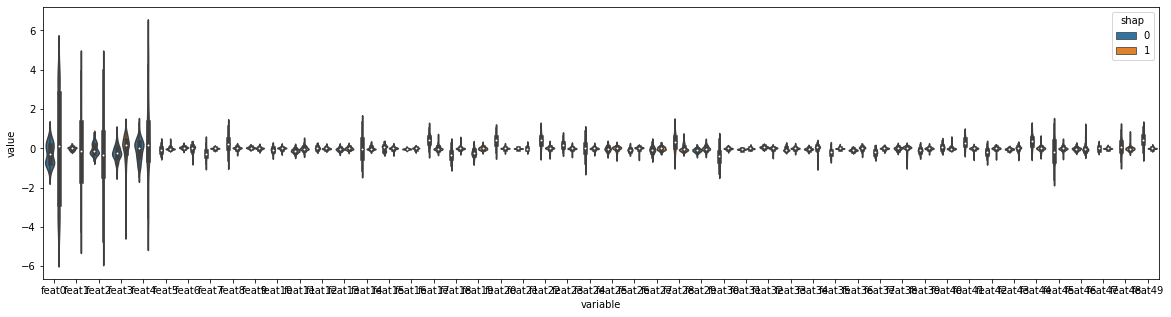

In [10]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.violinplot(x="variable", y="value", data=l, hue="shap", ax=ax)

## Dimensionality Reduction

In [11]:
def umap_embedding(
    values: np.array,
    n_components: int = 2,
    n_neighbors: int = 200,
    min_dist: float = 0.0,
    random_state: int = seed,
):
    embedding = UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state,
    ).fit_transform(values)
    return embedding

### Using Raw Values

In [12]:
# for colouring points in scatter plots
c = ["red"] * len(y)
for i in range(len(y)):
    if y[i] == 1:
        c[i] = "blue"

In [13]:
X_2d = umap_embedding(X)

The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11002. The TBB threading layer is disabled.


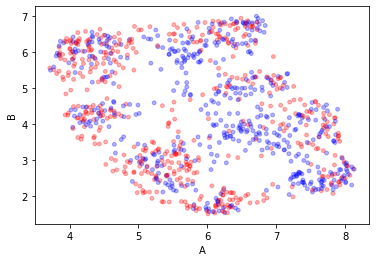

In [14]:
fig, ax = plt.subplots()
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(X_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": alpha, "s": size, "color": c},
);

### Using SHAP Values

In [17]:
sv_2d = umap_embedding(sv)

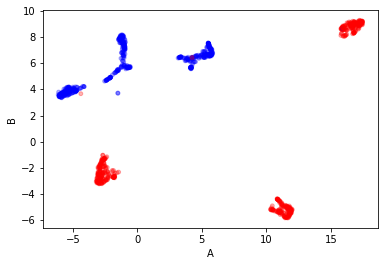

In [18]:
fig, ax = plt.subplots()
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": alpha, "s": size, "color": c},
);

## Clustering

In [21]:
def cluster_labels(embedding: np.array, n_clusters: int, random_state: int = seed):
    return DBSCAN(eps=1.5, min_samples=20).fit(embedding).labels_

In [22]:
def get_cmap(cluster_labels):
    colours = [
        "#e60049",
        "#0bb4ff",
        "#50e991",
        "#e6d800",
        "#9b19f5",
        "#ffa300",
        "#dc0ab4",
        "#b3d4ff",
        "#00bfa0",
    ]
    cmap = []
    for l in cluster_labels:
        if l == -1:
            cmap.append("grey")
        else:
            cmap.append(colours[l])
    return cmap

### Using Raw Embedding

In [23]:
X_2d_labels = cluster_labels(X_2d, n_clusters=n_clusters_per_class * 2)
X_cmap = get_cmap(X_2d_labels)

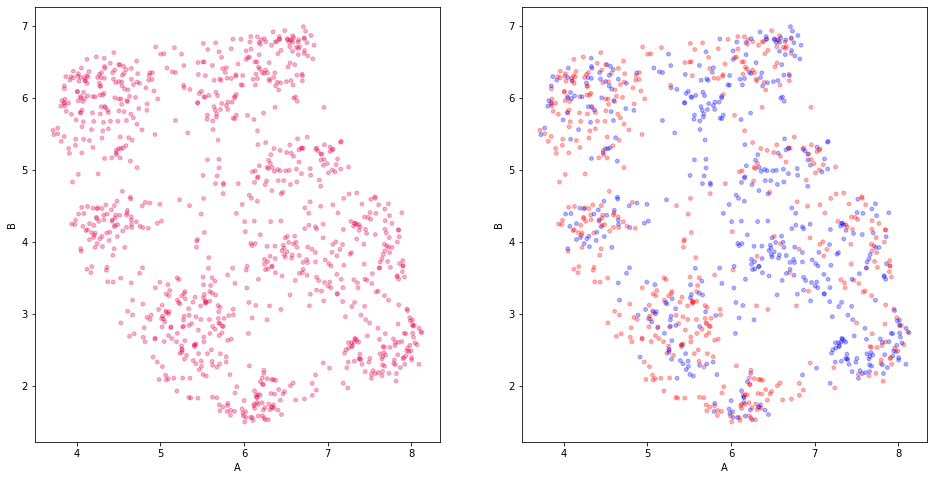

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(X_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax[0],
    scatter_kws={"alpha": alpha, "s": size, "color": X_cmap},
)
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(X_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax[1],
    scatter_kws={"alpha": alpha, "s": size, "color": c},
);

### Using SHAP Embedding

In [25]:
sv_2d_labels = cluster_labels(sv_2d, n_clusters=n_clusters_per_class * 2)
sv_cmap = get_cmap(sv_2d_labels)

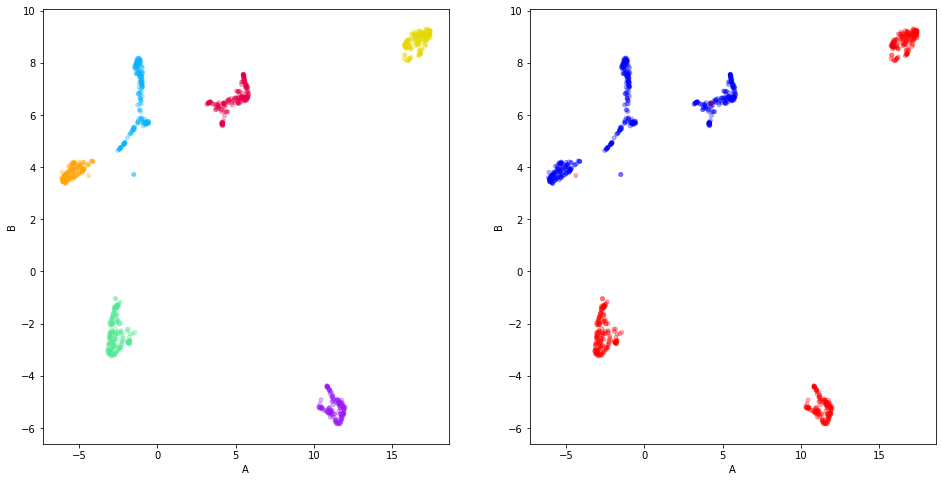

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax[0],
    scatter_kws={"alpha": alpha, "s": size, "color": sv_cmap},
)
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax[1],
    scatter_kws={"alpha": alpha, "s": size, "color": c},
);

## Cluster Descriptions

In [27]:
df_X = df_raw.drop("shap", axis=1)

In [28]:
def skoperules_models(
    X: pd.DataFrame,
    y: np.array,
    labels: np.array,
    n_estimators: int = 10,
    recall_min: float = 0.2,
    max_depth: int = 4,
    max_depth_duplication: int = 4,
    max_samples: float = 1.0,
    random_state: int = seed,
):
    X["cluster"] = labels
    sr_models = {}
    for cluster in X["cluster"].value_counts().index.sort_values():
        Xc = X.drop("cluster", axis=1)
        yc = (X["cluster"] == cluster) * 1
        sr = SkopeRules(
            feature_names=Xc.columns,
            random_state=random_state,
            n_estimators=n_estimators,
            recall_min=recall_min,
            max_depth=max_depth,
            max_depth_duplication=max_depth_duplication,
            max_samples=max_samples,
            max_features=None
        )
        sr.fit(Xc, yc)
        sr_models[cluster] = sr
    return sr_models

In [29]:
sv_models = skoperules_models(df_X, y, sv_2d_labels)

In [30]:
for cluster in sv_models.keys():
    print(f"Cluster {cluster}")
    if len(sv_models[cluster].rules_) == 0:
        print("N/A")
    else:
        for i, rule in enumerate(sv_models[cluster].rules_):
            if i == 0:
                for line in rule[0].split(" and "):
                    print(f"\t{line}")
                print(f"Precision: {rule[1][0]:.4f}")
                print(f"Recall   : {rule[1][1]:.4f}")
    print()

Cluster 0
	feat0 <= -0.20297465473413467
	feat1 > -0.018756963312625885
	feat2 > -0.0010625378345139325
	feat3 > -0.9125521779060364
Precision: 0.9645
Recall   : 0.7273

Cluster 1
	feat0 > -0.23964494466781616
	feat30 > -1.0404006242752075
	feat4 > 0.13320420682430267
Precision: 0.9909
Recall   : 0.5924

Cluster 2
	feat0 > -0.30511507391929626
	feat1 > -0.03494706191122532
	feat2 <= 0.1910397857427597
	feat4 <= -0.27254410088062286
Precision: 0.9521
Recall   : 0.7680

Cluster 3
	feat0 <= -0.30721135437488556
	feat1 <= -0.028290685266256332
	feat2 > 0.061838043853640556
	feat4 <= 0.49354971945285797
Precision: 0.9850
Recall   : 0.8086

Cluster 4
	feat0 <= -0.34881941974163055
	feat2 <= -0.04451247118413448
	feat27 > -0.4160826951265335
	feat9 > -0.0913991704583168
Precision: 0.9677
Recall   : 0.9740

Cluster 5
	feat0 > -0.2849038243293762
	feat1 <= -0.05200823396444321
	feat3 > -0.6209039092063904
	feat4 <= -0.18070042878389359
Precision: 0.9923
Recall   : 0.9773

